In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from diffusers import UNet2DModel, DDPMScheduler
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 8
    eval_batch_size = 8  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'ddpm-butterflies-128-8-1-without-withplt'  # the model namy locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()



c:\Users\User\anaconda3\envs\env4\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\User\anaconda3\envs\env4\lib\site-packages\diffusers\models\transformers\transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [2]:
from datasets import load_dataset

config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split="train")

Repo card metadata block was not found. Setting CardData to empty.


In [3]:
dataset

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

C:\Users\User\AppData\Local\Temp\ipykernel_11492\1829702657.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


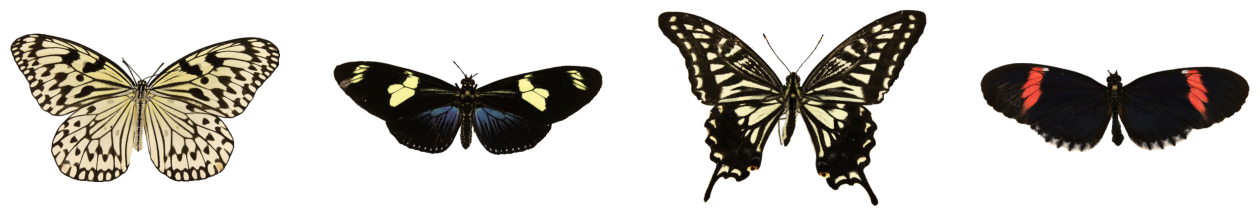

In [4]:

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [5]:

from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [6]:

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

In [7]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [8]:
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"  
      ),
)

In [9]:
sample_image = dataset[0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)

Input shape: torch.Size([1, 3, 128, 128])


In [10]:
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 128, 128])


In [11]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

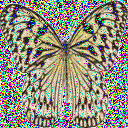

In [12]:
import torch
from PIL import Image

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [13]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

In [15]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [16]:
from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size, 
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [17]:
import os
import torch
import torch.nn.functional as F
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from pytorch_fid.inception import InceptionV3
import numpy as np
from scipy.linalg import sqrtm

def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def calculate_fid(real_images, fake_images, device):
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    model = InceptionV3([block_idx]).to(device)

    def get_activations(images):
        images = images.to(device)
        if images.size(1) == 1:
            images = images.repeat(1, 3, 1, 1)
        images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
        pred = model(images)[0]
        pred = pred.cpu().numpy()
        return pred

    act1 = get_activations(real_images)
    act2 = get_activations(fake_images)

    act1 = act1.reshape(act1.shape[0], -1)
    act2 = act2.reshape(act2.shape[0], -1)

    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)

    fid = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    return fid

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance."""
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        print("fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean)

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")
    
    # Prepare everything
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Metrics
    psnr = PeakSignalNoiseRatio().to(accelerator.device)
    ssim = StructuralSimilarityIndexMeasure().to(accelerator.device)

    # Lists to store metrics
    loss_list = []
    psnr_list = []
    ssim_list = []
    fid_list = []

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            # Log loss
            loss_list.append(loss.item())
            
            progress_bar.update(1)
            logs = {"loss": loss.item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # Calculate metrics once per epoch
        psnr_val = psnr(noisy_images, clean_images).item()
        ssim_val = ssim(noisy_images, clean_images).item()
        fid_val = calculate_fid(clean_images, noisy_images, device=accelerator.device)

        psnr_list.append(psnr_val)
        ssim_list.append(ssim_val)
        fid_list.append(fid_val)

        epoch_logs = {"psnr": psnr_val, "ssim": ssim_val, "fid": fid_val}
        tqdm.write(f"Epoch {epoch + 1} - PSNR: {psnr_val}, SSIM: {ssim_val}, FID: {fid_val}")
        accelerator.log(epoch_logs, step=global_step)

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

    # Plotting the metrics
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 2, 1)
    plt.plot(loss_list, label='Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(psnr_list, label='PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(ssim_list, label='SSIM')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(fid_list, label='FID')
    plt.xlabel('Epoch')
    plt.ylabel('FID')
    plt.legend()

    plt.tight_layout()
    plt.show()




Launching training on one GPU.


c:\Users\User\anaconda3\envs\env4\lib\site-packages\torchmetrics\utilities\prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
c:\Users\User\anaconda3\envs\env4\lib\site-packages\torchmetrics\utilities\prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]c:\Users\User\anaconda3\envs\env4\lib\site-packages\diffusers\configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct

Epoch 1 - PSNR: 5.804436683654785, SSIM: 0.1267818659543991, FID: 149.8871539153008


Epoch 0: 100%|██████████| 125/125 [00:56<00:00,  2.22it/s, loss=0.0722, lr=2.5e-5, step=124]

                                                                                      

Epoch 2 - PSNR: 6.0817484855651855, SSIM: 0.16957496106624603, FID: 158.15442667575726


Epoch 2: 100%|██████████| 125/125 [00:54<00:00,  2.54it/s, loss=0.0496, lr=7.5e-5, step=374] 

Epoch 3 - PSNR: 6.519426345825195, SSIM: 0.1846381425857544, FID: 169.40577169099075


Epoch 2: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s, loss=0.0496, lr=7.5e-5, step=374]

                                                                                         

Epoch 4 - PSNR: 6.4637064933776855, SSIM: 0.251742959022522, FID: 151.38062798008045


Epoch 4: 100%|██████████| 125/125 [00:53<00:00,  2.59it/s, loss=0.052, lr=9.99e-5, step=624]  

Epoch 5 - PSNR: 8.010443687438965, SSIM: 0.3531336784362793, FID: 162.71915428658883


Epoch 4: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s, loss=0.052, lr=9.99e-5, step=624]

                                                                                          

Epoch 6 - PSNR: 5.695626735687256, SSIM: 0.11642621457576752, FID: 161.55071557188631


Epoch 6: 100%|██████████| 125/125 [00:54<00:00,  2.62it/s, loss=0.0111, lr=9.9e-5, step=874]  

Epoch 7 - PSNR: 5.13161563873291, SSIM: 0.07136709243059158, FID: 161.5690656538065


Epoch 6: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s, loss=0.0111, lr=9.9e-5, step=874]

                                                                                          

Epoch 8 - PSNR: 5.93861722946167, SSIM: 0.10141918063163757, FID: 149.29239837796058


Epoch 8: 100%|██████████| 125/125 [00:53<00:00,  2.61it/s, loss=0.00338, lr=9.71e-5, step=1124]

Epoch 9 - PSNR: 4.2541913986206055, SSIM: 0.016450565308332443, FID: 142.52712099471023


Epoch 8: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s, loss=0.00338, lr=9.71e-5, step=1124]

                                                                                           

Epoch 10 - PSNR: 5.411631107330322, SSIM: 0.08614340424537659, FID: 154.1722683712143


Epoch 10: 100%|██████████| 125/125 [00:56<00:00,  2.44it/s, loss=0.0108, lr=9.44e-5, step=1374] 

Epoch 11 - PSNR: 5.011914253234863, SSIM: 0.1241142600774765, FID: 148.9753490687997


Epoch 10: 100%|██████████| 125/125 [00:56<00:00,  2.22it/s, loss=0.0108, lr=9.44e-5, step=1374]

                                                                                             

Epoch 12 - PSNR: 4.555325508117676, SSIM: 0.029718337580561638, FID: 140.50791450131078


Epoch 12: 100%|██████████| 125/125 [00:56<00:00,  2.61it/s, loss=0.0224, lr=9.08e-5, step=1624] 

Epoch 13 - PSNR: 6.464633464813232, SSIM: 0.18199244141578674, FID: 149.7251220897611


Epoch 12: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s, loss=0.0224, lr=9.08e-5, step=1624]

                                                                                            

Epoch 14 - PSNR: 5.401967525482178, SSIM: 0.16583339869976044, FID: 149.50610086988135


Epoch 14: 100%|██████████| 125/125 [00:56<00:00,  2.59it/s, loss=0.0101, lr=8.65e-5, step=1874] 

Epoch 15 - PSNR: 6.526435852050781, SSIM: 0.1265353560447693, FID: 151.45130061323616


Epoch 14: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s, loss=0.0101, lr=8.65e-5, step=1874]

                                                                                            

Epoch 16 - PSNR: 7.262207508087158, SSIM: 0.179273784160614, FID: 169.600824709023


Epoch 16: 100%|██████████| 125/125 [00:54<00:00,  2.50it/s, loss=0.0215, lr=8.16e-5, step=2124] 

Epoch 17 - PSNR: 6.361529350280762, SSIM: 0.23493722081184387, FID: 157.87418178016813


Epoch 16: 100%|██████████| 125/125 [00:54<00:00,  2.27it/s, loss=0.0215, lr=8.16e-5, step=2124]

                                                                                            

Epoch 18 - PSNR: 5.1143975257873535, SSIM: 0.10844019055366516, FID: 149.8622887807996


Epoch 18: 100%|██████████| 125/125 [00:54<00:00,  2.62it/s, loss=0.00941, lr=7.6e-5, step=2374] 

Epoch 19 - PSNR: 5.170238018035889, SSIM: 0.11951988190412521, FID: 134.1338236105726


Epoch 18: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s, loss=0.00941, lr=7.6e-5, step=2374]

                                                                                           

Epoch 20 - PSNR: 5.741006374359131, SSIM: 0.09757004678249359, FID: 161.19206866044166


Epoch 20: 100%|██████████| 125/125 [00:52<00:00,  2.75it/s, loss=0.0084, lr=6.99e-5, step=2624] 

Epoch 21 - PSNR: 5.011914253234863, SSIM: 0.1241142600774765, FID: 148.9753490687997


Epoch 20: 100%|██████████| 125/125 [00:52<00:00,  2.40it/s, loss=0.0084, lr=6.99e-5, step=2624]

                                                                                             

Epoch 22 - PSNR: 4.555325508117676, SSIM: 0.029718337580561638, FID: 140.50791450131078


Epoch 22: 100%|██████████| 125/125 [00:52<00:00,  2.58it/s, loss=0.0194, lr=6.35e-5, step=2874] 

Epoch 23 - PSNR: 6.464633464813232, SSIM: 0.18199244141578674, FID: 149.7251220897611


Epoch 22: 100%|██████████| 125/125 [00:52<00:00,  2.36it/s, loss=0.0194, lr=6.35e-5, step=2874]

                                                                                            

Epoch 24 - PSNR: 5.401967525482178, SSIM: 0.16583339869976044, FID: 149.50610086988135


Epoch 24: 100%|██████████| 125/125 [00:52<00:00,  2.60it/s, loss=0.00886, lr=5.68e-5, step=3124]

Epoch 25 - PSNR: 6.526435852050781, SSIM: 0.1265353560447693, FID: 151.45130061323616


Epoch 24: 100%|██████████| 125/125 [00:52<00:00,  2.37it/s, loss=0.00886, lr=5.68e-5, step=3124]

                                                                                            

Epoch 26 - PSNR: 7.262207508087158, SSIM: 0.179273784160614, FID: 169.600824709023


Epoch 26: 100%|██████████| 125/125 [00:53<00:00,  2.64it/s, loss=0.0198, lr=5e-5, step=3374]    

Epoch 27 - PSNR: 6.361529350280762, SSIM: 0.23493722081184387, FID: 157.87418178016813


Epoch 26: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s, loss=0.0198, lr=5e-5, step=3374]

                                                                                             

Epoch 28 - PSNR: 5.1143975257873535, SSIM: 0.10844019055366516, FID: 149.8622887807996


Epoch 28: 100%|██████████| 125/125 [00:52<00:00,  2.69it/s, loss=0.0085, lr=4.32e-5, step=3624] 

Epoch 29 - PSNR: 5.170238018035889, SSIM: 0.11951988190412521, FID: 134.1338236105726


Epoch 28: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s, loss=0.0085, lr=4.32e-5, step=3624]

                                                                                             

Epoch 30 - PSNR: 5.741006374359131, SSIM: 0.09757004678249359, FID: 161.19206866044166


Epoch 30: 100%|██████████| 125/125 [00:53<00:00,  2.59it/s, loss=0.00752, lr=3.65e-5, step=3874]

Epoch 31 - PSNR: 5.011914253234863, SSIM: 0.1241142600774765, FID: 148.9753490687997


Epoch 30: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s, loss=0.00752, lr=3.65e-5, step=3874]

                                                                                            

Epoch 32 - PSNR: 4.555325508117676, SSIM: 0.029718337580561638, FID: 140.50791450131078


Epoch 32: 100%|██████████| 125/125 [00:54<00:00,  2.63it/s, loss=0.0181, lr=3.01e-5, step=4124] 

Epoch 33 - PSNR: 6.464633464813232, SSIM: 0.18199244141578674, FID: 149.7251220897611


Epoch 32: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s, loss=0.0181, lr=3.01e-5, step=4124]

                                                                                           

Epoch 34 - PSNR: 5.401967525482178, SSIM: 0.16583339869976044, FID: 149.50610086988135


Epoch 34: 100%|██████████| 125/125 [00:55<00:00,  2.62it/s, loss=0.00791, lr=2.4e-5, step=4374]  

Epoch 35 - PSNR: 6.526435852050781, SSIM: 0.1265353560447693, FID: 151.45130061323616


Epoch 34: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s, loss=0.00791, lr=2.4e-5, step=4374]

                                                                                            

Epoch 36 - PSNR: 7.262207508087158, SSIM: 0.179273784160614, FID: 169.600824709023


Epoch 36: 100%|██████████| 125/125 [00:54<00:00,  2.50it/s, loss=0.0187, lr=1.84e-5, step=4624] 

Epoch 37 - PSNR: 6.361529350280762, SSIM: 0.23493722081184387, FID: 157.87418178016813


Epoch 36: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s, loss=0.0187, lr=1.84e-5, step=4624]

                                                                                             

Epoch 38 - PSNR: 5.1143975257873535, SSIM: 0.10844019055366516, FID: 149.8622887807996


Epoch 38: 100%|██████████| 125/125 [00:55<00:00,  2.60it/s, loss=0.00787, lr=1.35e-5, step=4874]

Epoch 39 - PSNR: 5.170238018035889, SSIM: 0.11951988190412521, FID: 134.1338236105726


Epoch 38: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s, loss=0.00787, lr=1.35e-5, step=4874]

                                                                                             

Epoch 40 - PSNR: 5.741006374359131, SSIM: 0.09757004678249359, FID: 161.19206866044166


Epoch 40: 100%|██████████| 125/125 [00:54<00:00,  2.42it/s, loss=0.00709, lr=9.15e-6, step=5124]

Epoch 41 - PSNR: 5.011914253234863, SSIM: 0.1241142600774765, FID: 148.9753490687997


Epoch 40: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s, loss=0.00709, lr=9.15e-6, step=5124]

                                                                                             

Epoch 42 - PSNR: 4.555325508117676, SSIM: 0.029718337580561638, FID: 140.50791450131078


Epoch 42: 100%|██████████| 125/125 [00:54<00:00,  2.60it/s, loss=0.0168, lr=5.61e-6, step=5374] 

Epoch 43 - PSNR: 6.464633464813232, SSIM: 0.18199244141578674, FID: 149.7251220897611


Epoch 42: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s, loss=0.0168, lr=5.61e-6, step=5374]

                                                                                            

Epoch 44 - PSNR: 5.401967525482178, SSIM: 0.16583339869976044, FID: 149.50610086988135


Epoch 44: 100%|██████████| 125/125 [00:54<00:00,  2.64it/s, loss=0.00732, lr=2.89e-6, step=5624] 

Epoch 45 - PSNR: 6.526435852050781, SSIM: 0.1265353560447693, FID: 151.45130061323616


Epoch 44: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s, loss=0.00732, lr=2.89e-6, step=5624]

                                                                                            

Epoch 46 - PSNR: 7.262207508087158, SSIM: 0.179273784160614, FID: 169.600824709023


Epoch 46: 100%|██████████| 125/125 [00:53<00:00,  2.68it/s, loss=0.0178, lr=1.05e-6, step=5874] 

Epoch 47 - PSNR: 6.361529350280762, SSIM: 0.23493722081184387, FID: 157.87418178016813


Epoch 46: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s, loss=0.0178, lr=1.05e-6, step=5874]

                                                                                             

Epoch 48 - PSNR: 5.1143975257873535, SSIM: 0.10844019055366516, FID: 149.8622887807996


Epoch 48: 100%|██████████| 125/125 [00:55<00:00,  2.64it/s, loss=0.00759, lr=1.17e-7, step=6124]

Epoch 49 - PSNR: 5.170238018035889, SSIM: 0.11951988190412521, FID: 134.1338236105726


Epoch 48: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s, loss=0.00759, lr=1.17e-7, step=6124]

                                                                                       

Epoch 50 - PSNR: 5.741006374359131, SSIM: 0.09757004678249359, FID: 161.19206866044166


100%|██████████| 1000/1000 [01:19<00:00, 12.58it/s]


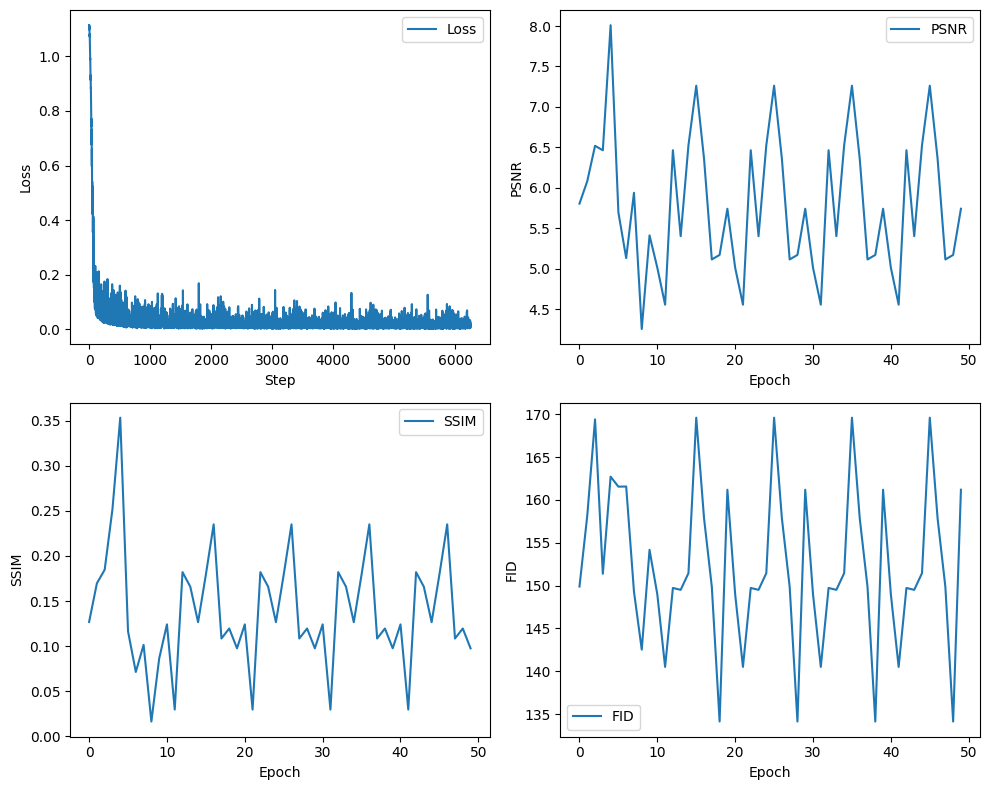

Epoch 49: 100%|██████████| 125/125 [02:15<00:00,  1.09s/it, loss=0.00669, lr=0, step=6249]


In [18]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

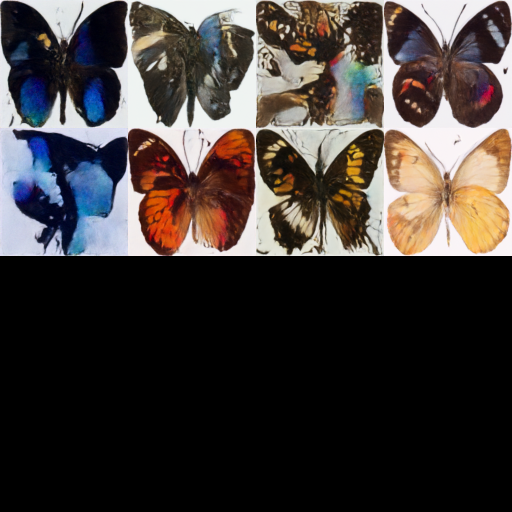

In [19]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])